In [82]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from astropy.io import fits
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
import glob
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import astropy.convolution as ac
import pandas as pd
from scipy.ndimage import zoom
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import sklearn

### We perform some analysis on disk center.

In [3]:
stokes = fits.open('qs_ph_disk_center_synth.fits')[0].data[:512,:512]
print(stokes.shape)

Ic = np.mean(stokes[:,:,0,-10:])

I_norm = stokes[:,:,0,:] / Ic
Q_norm = stokes[:,:,1,:] / Ic
U_norm = stokes[:,:,2,:] / Ic
V_norm = stokes[:,:,3,:] / Ic

x, y = 200, 200
ll = np.linspace(6301, 6303, 201)

(512, 512, 4, 201)


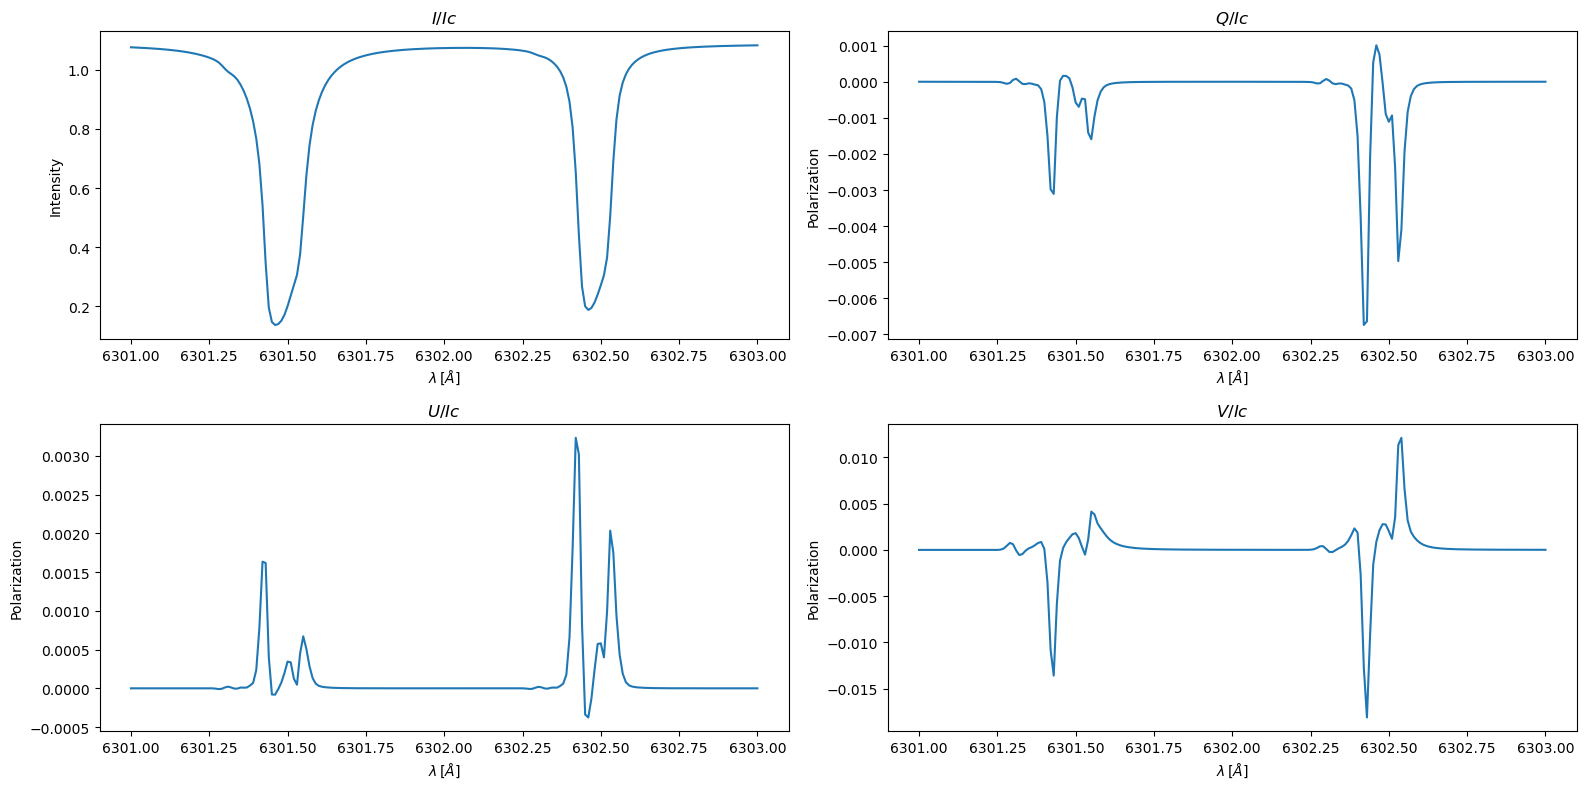

In [5]:
plt.figure(figsize=(16, 8))
plt.subplot(221)
plt.plot(ll, I_norm[y, x], label='I/Ic')
plt.title('$I/Ic$')
plt.xlabel(r'$\lambda\,[{\AA}]$')
plt.ylabel('Intensity')

plt.subplot(222)
plt.plot(ll, Q_norm[y, x], label='Q/Ic')
plt.title(r'$Q/Ic$')
plt.xlabel(r'$\lambda\,[{\AA}]$')
plt.ylabel('Polarization')

plt.subplot(223)
plt.plot(ll, U_norm[y, x], label='U/Ic')
plt.title('$U/Ic$')
plt.xlabel(r'$\lambda\,[{\AA}]$')
plt.ylabel('Polarization')

plt.subplot(224)
plt.plot(ll, V_norm[y, x], label='V/Ic')
plt.title('$V/Ic$')
plt.xlabel(r'$\lambda\,[{\AA}]$')
plt.ylabel('Polarization')

plt.tight_layout()
plt.show()

### We have few equations here:

$$B_{||}\propto V,\,\,\,B_{\perp}\propto\sqrt{Q^2+U^2},\,\,\,\varphi\propto\tan^{-1}{(U/Q)}.$$

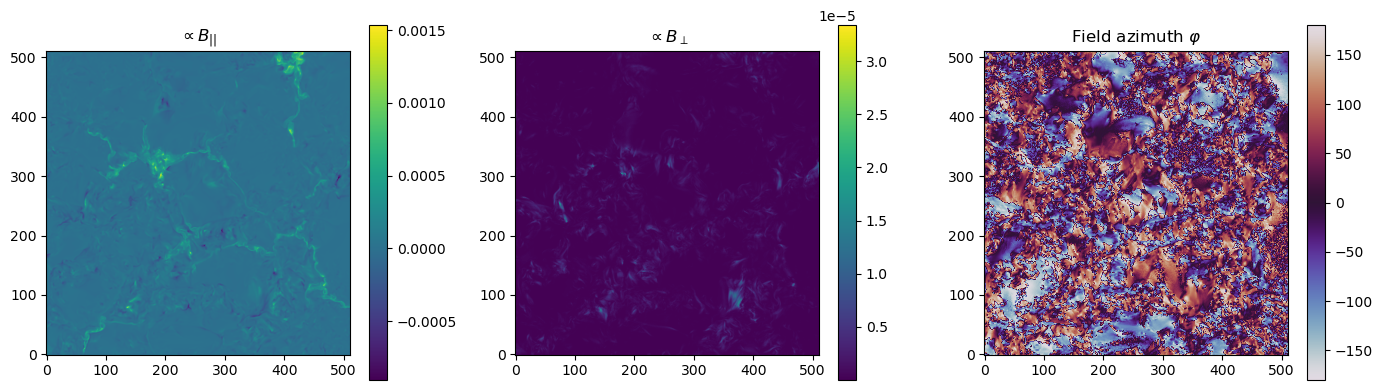

In [8]:
B_parallel = stokes[:,:,3,:]
B_perpendicular = np.sqrt((stokes[:,:,1,:])**2 + (stokes[:,:,2,:])**2)
phi = np.degrees(np.arctan2((stokes[:,:,1,:]), (stokes[:,:,2,:])))

plt.figure(figsize=(14, 4))
plt.subplot(131)
plt.title(r'$\propto B_{||}$')
plt.imshow(B_parallel[:,:,0], cmap='viridis', origin='lower')
plt.colorbar()

plt.subplot(132)
plt.title(r'$\propto B_{\perp}$')
plt.imshow(B_perpendicular[:,:,0], cmap='viridis', origin='lower')
plt.colorbar()

plt.subplot(133)
plt.title(r'Field azimuth $\varphi$')
plt.imshow(phi[:,:,0], cmap='twilight', origin='lower')
plt.colorbar()

plt.tight_layout()
plt.show()

### We perform analysis on the pole.

In [29]:
atmos = fits.open('pole_atm_original.fits')[0].data
mag_field = atmos[4,30]
inclination = np.radians(atmos[6,30])
azimuth = np.radians(atmos[7,30])/2 

Bz = mag_field * np.cos(inclination)
Bx = mag_field * np.cos(azimuth) * np.sin(inclination)
By = mag_field * np.sin(azimuth) * np.sin(inclination)

Bh = np.sqrt(Bx**2 + By**2)

In [18]:
def merge_subregions(filename, rows, cols, overlap, x_size, y_size):

    ef_x_size = x_size - overlap
    ef_y_size = y_size - overlap
    merged_size_x = ef_x_size * rows + overlap
    merged_size_y = ef_y_size * cols + overlap
    merged_array = np.zeros((merged_size_x, merged_size_y, 9))
    for i in range(rows):
        for j in range(cols):
            subregion_filename = f'{filename}_{i}_{j}.fits'
            subregion_data = fits.open(subregion_filename)[0].data
            x_start = i * ef_x_size
            y_start = j * ef_y_size
            merged_array[x_start:x_start+x_size, y_start:y_start+y_size, :] = subregion_data

    return merged_array

filename = 'spc_special_part'
rows = 4
cols = 2
overlap = 6
x_size = 111 
y_size = 93   
spc_0 = merge_subregions(filename, rows, cols, overlap, x_size, y_size)
print('Spatially-coupled inferred file shape is:', spc_0.shape)

Spatially-coupled inferred file shape is: (426, 180, 9)


### Spatially-coupled inferred parameters need to be rebinned and deprojected, to match the original.

In [19]:
def rebin(data, bin_factor):
    zoom_factor = (3.605, 3.6)  
    rebinned_data = np.empty((1536, 648, data.shape[2]))  
    for i in range(data.shape[2]):  
        rebinned_data[:, :, i] = zoom(data[:, :, i], zoom_factor, order=1)
    return rebinned_data

def deproject(data, final_width):
    deprojected_data = np.empty((data.shape[0], final_width, data.shape[2]))  
    for i in range(data.shape[2]): 
        x, y = data[:, :, i].shape
        zoom_factor = (1, final_width / y)  
        deprojected_data[:, :, i] = zoom(data[:, :, i], zoom_factor, order=1)
    return deprojected_data

In [20]:
rebinned_spc = rebin(spc_0, 3.6)
spc = deproject(rebinned_spc, 1536)
print(spc.shape)

(1536, 1536, 9)


### We check how inferred and original azimuth/inclination correlate.
#### There is a discrepancy since inferred azimuth has values $0-180^{\circ}$ but original values are $0-360^{\circ}$,

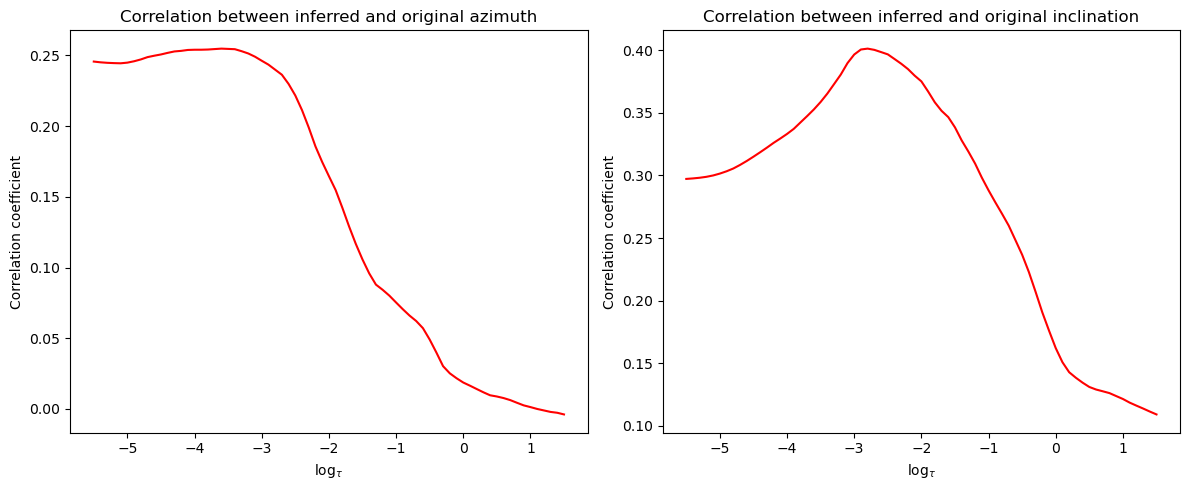

In [105]:
o_depths = atmos[0,:,0,0]

cc_az_spc= []
for i in range(len(o_depths)):
    correlation = np.corrcoef(atmos[7,i].flatten(), np.degrees(spc[:,:,2]).flatten())[0, 1]
    cc_az_spc.append(correlation)

cc_inc_spc = []
for i in range(len(o_depths)):
    correlation = np.corrcoef(atmos[6,i].flatten(), np.degrees(spc[:,:,1]).flatten())[0, 1]
    cc_inc_spc.append(correlation)

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(o_depths, cc_az_spc, color='red')
plt.xlabel(r'$\log_{\tau}$')
plt.ylabel('Correlation coefficient')
plt.title(r'Correlation between inferred and original azimuth')

plt.subplot(122)
plt.plot(o_depths, cc_inc_spc, color='red')
plt.xlabel(r'$\log_{\tau}$')
plt.ylabel('Correlation coefficient')
plt.title('Correlation between inferred and original inclination')

plt.tight_layout()
plt.show()

### Zeroth attempt: plain calculation.
#### No preprocessing techniques were applied to address disambiguation seriously.

In [22]:
Bx_spc = spc[:,:,0] * np.sin(spc[:,:,1]) * np.cos(spc[:,:,2])
By_spc = spc[:,:,0] * np.sin(spc[:,:,1]) * np.sin(spc[:,:,2])

Bh_spc = np.sqrt(Bx_spc**2 + By_spc**2)

### First attempt: acute angle method (AAM). 
#### Adjustment of the azimuth based on neighboring values to ensure minimal change between adjacent pixels.

#### We can maybe define 'cost' function that penalizes azimuthal differences between a pixel and all its neighbors. 

$$C_f=\sum_{k}min(|\chi-\chi_k|,\,|\chi-\chi_k\pm180^{\circ}|).$$

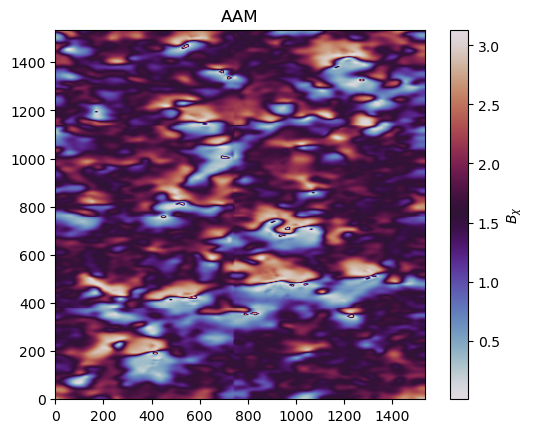

In [115]:
def AAM_with_weights(azimuth, B_strength, max_iterations=10, threshold=1e-3):
    azimuth = np.degrees(azimuth) 
    shape = azimuth.shape
    updated_azimuth = azimuth.copy()

    for _ in range(max_iterations):
        azimuth_prev = updated_azimuth.copy()
        for i in range(1, shape[0] - 1):
            for j in range(1, shape[1] - 1):
            
                neighbors = [
                    updated_azimuth[i-1, j], updated_azimuth[i+1, j],
                    updated_azimuth[i, j-1], updated_azimuth[i, j+1],
                    updated_azimuth[i-1, j-1], updated_azimuth[i-1, j+1],
                    updated_azimuth[i+1, j-1], updated_azimuth[i+1, j+1]
                ]
                
                # corresponding magnetic field strengths for weighting
                weights = [
                    B_strength[i-1, j], B_strength[i+1, j],
                    B_strength[i, j-1], B_strength[i, j+1],
                    B_strength[i-1, j-1], B_strength[i-1, j+1],
                    B_strength[i+1, j-1], B_strength[i+1, j+1]
                ]

                # computing weighted differences with current azimuth
                diffs = [np.abs(updated_azimuth[i, j] - neighbor) for neighbor in neighbors]
                corrected_diffs = [diff if diff <= 90 else np.abs(diff - 180) for diff in diffs]
                weighted_diffs = np.sum([w * diff for w, diff in zip(weights, corrected_diffs)])
                original_weighted_diffs = np.sum([w * diff for w, diff in zip(weights, diffs)])

                # correcting the azimuth based on weighted differences
                if weighted_diffs > original_weighted_diffs:
                    updated_azimuth[i, j] += 180
                updated_azimuth[i, j] %= 360  # Keeping within 0-360° range

        if np.max(np.abs(updated_azimuth - azimuth_prev)) < threshold:
            break

    return np.radians(updated_azimuth)  

azimuth_r = AAM_with_weights(spc[:,:,2], spc[:,:,0])
plt.imshow(azimuth_r, cmap='twilight', origin='lower')
plt.colorbar(label=r'$B_{\chi}$')
plt.title('AAM')
plt.show()

In [116]:
B = spc[:,:,0]
Bz_aam = B * np.cos(spc[:,:,1])
Bx_aam = B * np.sin(spc[:,:,1]) * np.cos(azimuth_r)
By_aam = B * np.sin(spc[:,:,1]) * np.sin(azimuth_r)

Bh_aam = np.sqrt(Bx_aam**2 + By_aam**2)

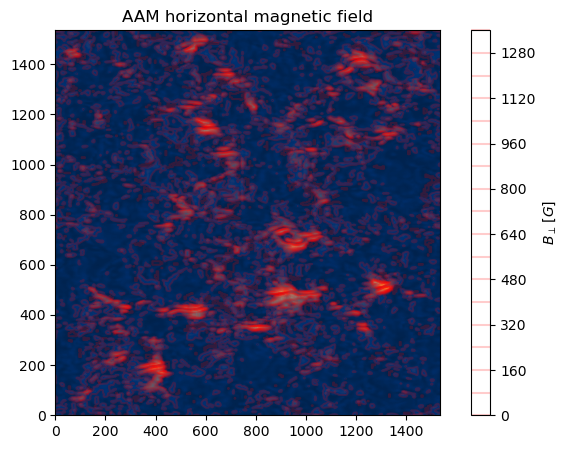

In [117]:
plt.figure(figsize=(8, 5))
plt.imshow(Bh_aam, cmap='cividis', origin='lower')
plt.contour(Bh_aam, levels=20, colors='red', alpha=0.2)  
plt.colorbar(label='$B_{\perp}\,[G]$')
plt.title('AAM horizontal magnetic field')
plt.show()

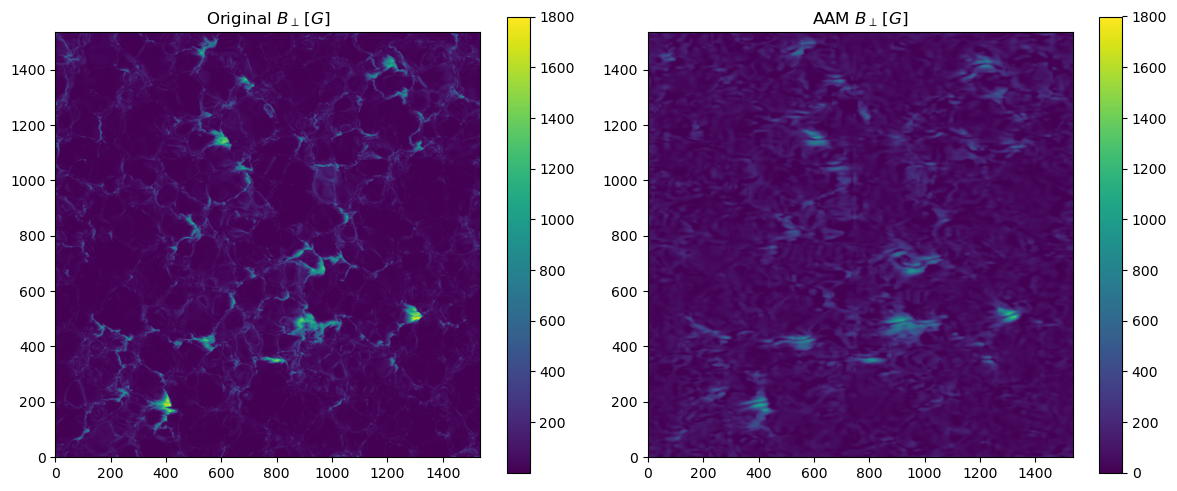

In [118]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.imshow(Bh, cmap='viridis', origin='lower', vmax=1800)
plt.title('Original $B_{\perp}\,[G]$')
plt.colorbar()

plt.subplot(122)
plt.imshow(Bh_aam, cmap='viridis', origin='lower', vmax=1800)
plt.title('AAM $B_{\perp}\,[G]$')
plt.colorbar()

plt.tight_layout()
plt.show()

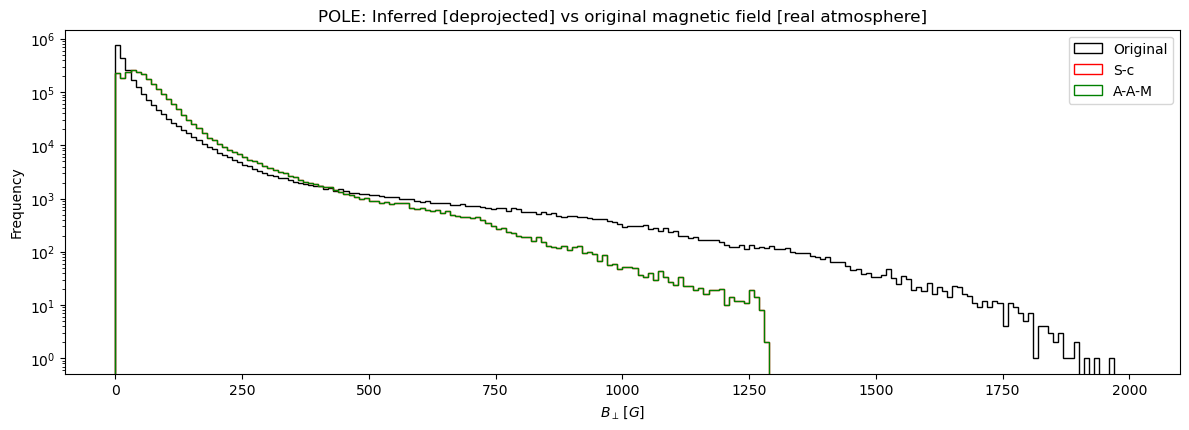

In [119]:
num_bins = 200

plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.hist(Bh.ravel(), num_bins, color='black', label=r'Original', 
         histtype='step', range=(0,2000))
plt.hist(Bh_spc.ravel(), num_bins, color='red', label=r'S-c', 
         histtype='step', range=(0,2000))
plt.hist(Bh_aam.ravel(), num_bins, color='green', label=r'A-A-M',
         histtype='step', range=(0,2000))

plt.title(r'POLE: Inferred [deprojected] vs original magnetic field [real atmosphere]')
plt.xlabel(r'$B_{\perp}\,[G]$')
plt.ylabel(r'Frequency')
plt.legend()

plt.yscale('log')
plt.tight_layout()
plt.show()

### Second attempt: Spherical geometry method (SGM).

In [56]:
def calculate_theta(delta, phi):
    return np.arccos(np.cos(delta) * np.cos(phi))

def calculate_beta(delta, phi, theta):
    return np.arccos(np.cos(delta) * np.sin(phi) / np.sin(theta))

def calculate_inclinations(gamma, theta, beta, chi):
    i1 = np.arccos(np.cos(gamma) * np.cos(theta) + np.sin(gamma) * np.sin(theta) * np.cos(beta - chi))
    i2 = np.arccos(np.cos(gamma) * np.cos(theta) + np.sin(gamma) * np.sin(theta) * np.cos(np.pi - (beta - chi)))
    return i1, i2

def classify_magnetic_fields(i1, i2):
    vertical_mask = (i1 <= np.radians(40)) | (i1 >= np.radians(140))
    horizontal_mask = (i1 >= np.radians(70)) & (i1 <= np.radians(110))
    
    classification = np.full(i1.shape, 'undetermined', dtype='object') 

    for condition, label in zip([vertical_mask, horizontal_mask], ['vertical', 'horizontal']):
        classification[condition] = label

    ambiguous_mask = (classification == 'vertical') & ((i2 <= np.radians(40)) | (i2 >= np.radians(140)))
    classification[ambiguous_mask] = 'ambiguous'
    
    return classification

In [58]:
B = spc[:,:,0]
gamma = spc[:,:,1]
chi = spc[:,:,2]

delta_values = np.linspace(np.radians(65), np.radians(90), B.shape[0])[:, None]
delta = np.tile(delta_values, (1, B.shape[1]))  

phi = np.zeros_like(delta)


theta = calculate_theta(delta, phi)
beta = calculate_beta(delta, phi, theta)

i1, i2 = calculate_inclinations(gamma, theta, beta, chi)
classification = classify_magnetic_fields(i1, i2)

i1 = np.degrees(i1)
i2 = np.degrees(i2)

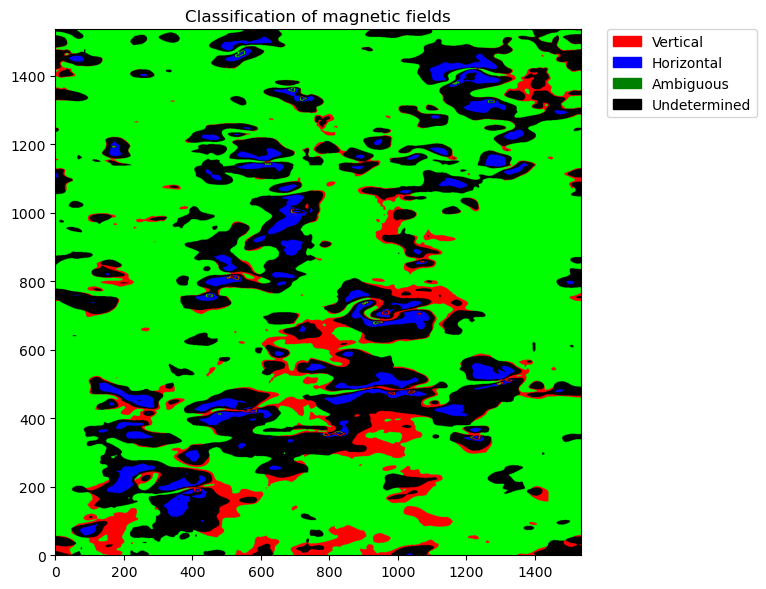

In [59]:
color_map = np.zeros(classification.shape + (3,))  # RGB channels
color_map[classification == 'vertical'] = [1, 0, 0]  # red for vertical
color_map[classification == 'horizontal'] = [0, 0, 1]  # blue for horizontal
color_map[classification == 'ambiguous'] = [0, 1, 0]  # green for ambiguous
color_map[classification == 'undetermined'] = [0, 0, 0]  #black for undetermined

plt.figure(figsize=(10, 6))
plt.imshow(color_map, origin='lower')
plt.title('Classification of magnetic fields')

legend_labels = {
    'Vertical': 'red',
    'Horizontal': 'blue',
    'Ambiguous': 'green',
    'Undetermined': 'black'
}

patches = [mpatches.Patch(color=color, label=label) for label, color in legend_labels.items()]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.tight_layout()
plt.show()

In [60]:
correct_inclination = np.where(classification == 'vertical', i1, i2)  

Bz_sgm = B * np.cos(correct_inclination)
Bx_sgm = B * np.sin(correct_inclination) * np.cos(chi)  
By_sgm = B * np.sin(correct_inclination) * np.sin(chi)

Bh_sgm = np.sqrt(Bx_sgm**2 + By_sgm**2)

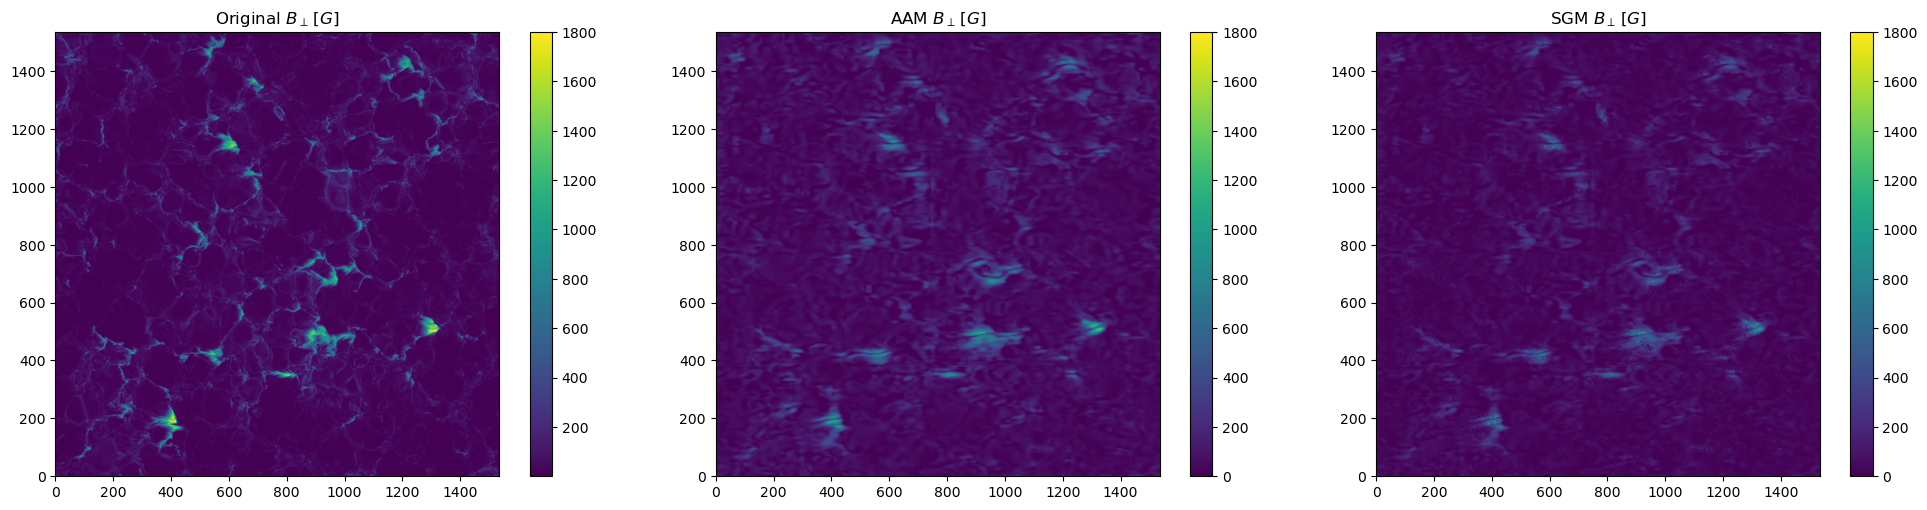

In [109]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.imshow(Bh, cmap='viridis', origin='lower', vmax=1800)
plt.title(r'Original $B_{\perp}\,[G]$')
plt.colorbar()

plt.subplot(132)
plt.imshow(Bh_aam, cmap='viridis', origin='lower', vmax=1800)
plt.title(r'AAM $B_{\perp}\,[G]$')
plt.colorbar()

plt.subplot(133)
plt.imshow(Bh_sgm, cmap='viridis', origin='lower', vmax=1800)
plt.title(r'SGM $B_{\perp}\,[G]$')
plt.colorbar()

plt.tight_layout()
plt.show()

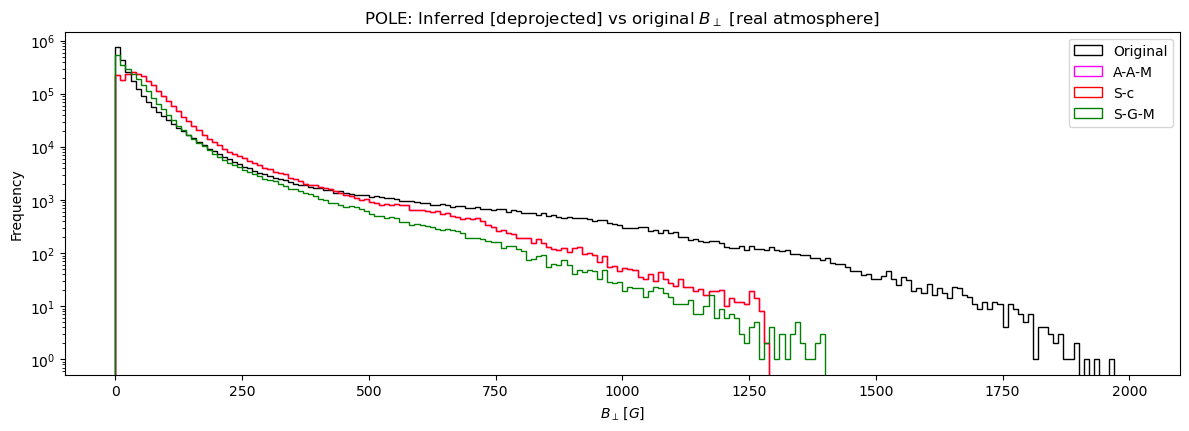

In [110]:
num_bins = 200

plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.hist(Bh.ravel(), num_bins, color='black', label=r'Original', 
         histtype='step', range=(0,2000))
plt.hist(Bh_aam.ravel(), num_bins, color='magenta', label=r'A-A-M',
         histtype='step', range=(0,2000))
plt.hist(Bh_spc.ravel(), num_bins, color='red', label=r'S-c',
         histtype='step', range=(0,2000))
plt.hist(Bh_sgm.ravel(), num_bins, color='green', label=r'S-G-M',
         histtype='step', range=(0,2000))

plt.title(r'POLE: Inferred [deprojected] vs original $B_{\perp}$ [real atmosphere]')
plt.xlabel(r'$B_{\perp}\,[G]$')
plt.ylabel(r'Frequency')
plt.legend()

plt.yscale('log')
plt.tight_layout()
plt.show()

In [63]:
correlation_aam = np.corrcoef(Bh.ravel(), Bh_aam.ravel())[0, 1]
correlation_sgm = np.corrcoef(Bh.ravel(), Bh_sgm.ravel())[0, 1]
correlation = np.corrcoef(Bh_aam.ravel(), Bh_sgm.ravel())[0, 1]
print(correlation_aam, correlation_sgm, correlation)

0.6316343463298497 0.5395669275905801 0.8464805131744098


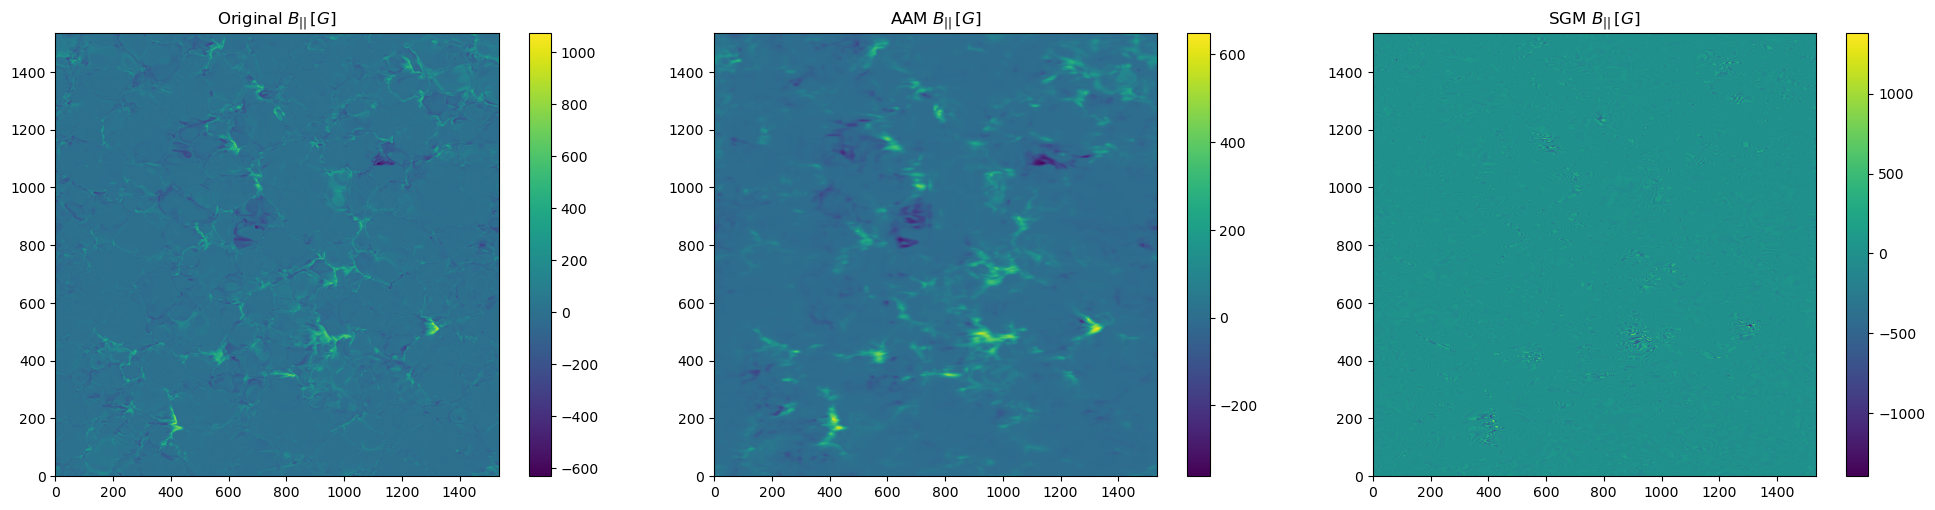

In [111]:
plt.figure(figsize=(20, 5))

plt.subplot(131)
plt.imshow(Bz, cmap='viridis', origin='lower')
plt.title(r'Original $B_{||}\,[G]$')
plt.colorbar()

plt.subplot(132)
plt.imshow(Bz_aam, cmap='viridis', origin='lower')
plt.title(r'AAM $B_{||}\,[G]$')
plt.colorbar()

plt.subplot(133)
plt.imshow(Bz_sgm, cmap='viridis', origin='lower')
plt.title(r'SGM $B_{||}\,[G]$')
plt.colorbar()

plt.tight_layout()
plt.show()

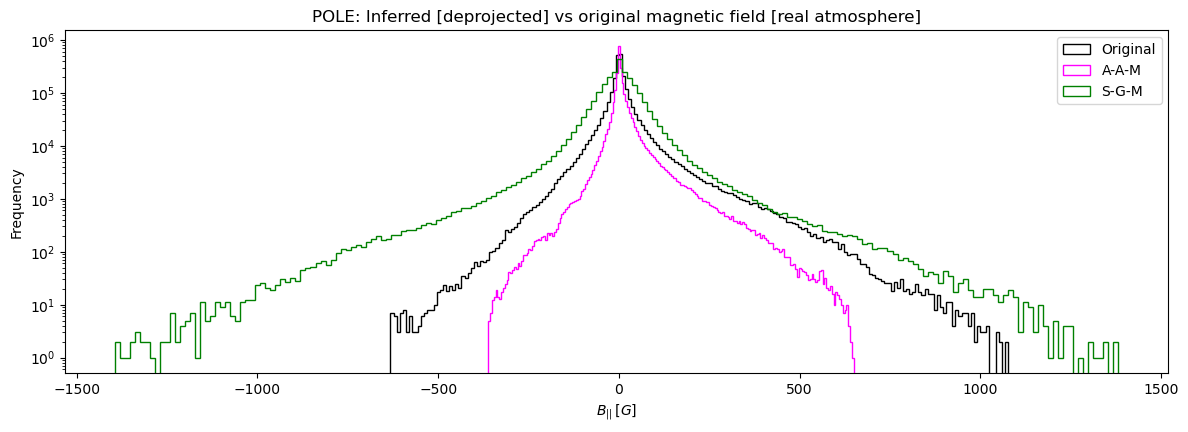

In [112]:
num_bins = 200

plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.hist(Bz.ravel(), num_bins, color='black', label=r'Original', 
         histtype='step')
plt.hist(Bz_aam.ravel(), num_bins, color='magenta', label=r'A-A-M',
         histtype='step')
#plt.hist(Bz.ravel(), num_bins, color='red', label=r'S-c',
 #        histtype='step')
plt.hist(Bz_sgm.ravel(), num_bins, color='green', label=r'S-G-M',
         histtype='step')

plt.title(r'POLE: Inferred [deprojected] vs original magnetic field [real atmosphere]')
plt.xlabel(r'$B_{||}\,[G]$')
plt.ylabel(r'Frequency')
plt.legend()

plt.yscale('log')
plt.tight_layout()
plt.show()

In [26]:
correlation_aam = np.corrcoef(Bz.ravel(), Bz_aam.ravel())[0, 1]
correlation_sgm = np.corrcoef(Bz.ravel(), Bz_sgm.ravel())[0, 1]
correlation = np.corrcoef(Bz_aam.ravel(), Bz_sgm.ravel())[0, 1]
print(correlation_aam, correlation_sgm, correlation)

0.5881198913326438 0.0009647672668279864 0.009510860386202209


### Third attempt: Bayesian inference - maybe this can be implemented on full FOV.

Estimated azimuth: 92.73421942961039


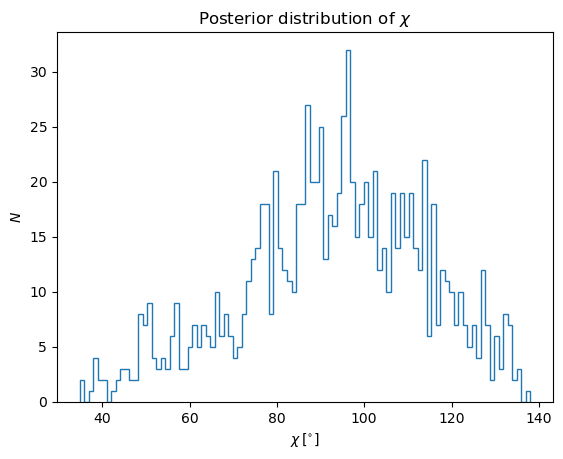

In [101]:
def bayesian_inference_azimuth_manual(azimuth_observed, n_samples=1000, step_size=5):
   
    def prior(azimuth):
        return 1 if (0 <= azimuth <= 360) else 0

    def likelihood(azimuth, observed_azimuth):
        sigma = 20
        return np.exp(-0.5 * ((observed_azimuth - azimuth) ** 2) / sigma**2)

    def posterior(azimuth, observed_azimuth):
        return likelihood(azimuth, observed_azimuth) * prior(azimuth)
    
    # Metropolis-Hastings sampler
    samples = np.zeros(n_samples)
    current_azimuth = np.random.uniform(0, 360) 
    for i in range(n_samples):
        proposal = current_azimuth + np.random.normal(0, step_size)
        p_current = posterior(current_azimuth, azimuth_observed)
        p_proposal = posterior(proposal, azimuth_observed)

        p_accept = p_proposal / p_current if p_current > 0 else 1
        
        if p_accept > np.random.rand():
            current_azimuth = proposal
        
        samples[i] = current_azimuth

    return samples

azimuth_observed = 90 
azimuth_samples = bayesian_inference_azimuth_manual(azimuth_observed)

azimuth_estimated = np.mean(azimuth_samples)
print(f'Estimated azimuth: {azimuth_estimated}')

import matplotlib.pyplot as plt
plt.hist(azimuth_samples, bins=100, histtype='step')
plt.xlabel(r'$\chi\,[^{\circ}]$')
plt.ylabel(r'$N$')
plt.title(r'Posterior distribution of $\chi$')
plt.show()